In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 13 19:41:56 2018

@author: slab

Module 6 used as AWG/marker:
    Channel 1 is I
    Channel 2 is Q
    Channel 3 is marker for readout pulse
    Channel 4 is indicator to take data. Should be connected to "Trigger" on
        Module 10.

Module 10 is used for reacout.
    Channel 1 is I
    Channel 2 is Q
"""

%pylab inline
from slab.instruments.keysight import KeysightLib as key
from slab.instruments.keysight import keysightSD1 as SD1
from slab.experiments.HVIExperiments import HVIExpLib as exp
import time
import numpy as np
import os
import threading
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdmn


AWG_BANDWIDTH = 10**9 #Samples per second
NUM_TRIALS = 100 #This is the number of different experiments, or how many values the parameter that is being varied (in this case sigma) will take
SIGMA_STEP=2 #This is the parameter step
READOUT_PULSE=100 #length in ns
READOUT_LENGTH = 1000
NUM_SWEEPS = 1000 #This is the total number of runs that will be averaged

In [ ]:
class KeysightSingleQubit:
    '''Class designed to implement a simple single qubit experiment given a pulse sequence. Note that this will not work for error correction or 
    anything else needing the FPGA (extend HVIEnabledQubitExperiment instead) or anything requiring more than 1 AWG and 1 digitizer module
    (it is impossible to trigger them in synch from Python using the manufacturer-provided code). In either case you will have to use the HVI
    technology.
    
    This currently only works for one hardware configuration. In particular, Module (slot) 6 is used as the AWG/marker, and Module 10 is used as
    the digitizer. On Module 6, channel 1 goes to the I input to the mixer, channel 2 goes to the Q input, channel 3 is the readout pulse, and
    channel 4 is the qubit pulse. Module 6, channel 3 (readout pulse) should also be connected to the trigger input of Module 10 (digitizer). On
    module 10, channel 1 is for readout of I component and channel 2 is for readout from Q component.'''
    
    
    
    def __init__(self, num_sweeps = NUM_SWEEPS, num_experiments = NUM_TRIALS, save_path = r"C:\Users\slab\Documents\Data",
                 sleep_time_between_trials = 500*1000): #1000*10000 if you want to watch sweep by eye
        '''Initializes the experiment.
        Params:
            num_sweeps: the number of total runs that will be averaged.
            num_experiments: The number of values that the parameter being varied will take (i.e. the number of unique experiments being done). 
                Equivalently, this is the number of arrays you'll expect to get back at the end of a single sweep.
            save_path: The path where the data is to be saved.
            sleep_time_between_trials: Sleep time in ns between triggers for each trial. Keep in mind that this should be at least the length
                of the longest trial, plus any qubit relaxation time. Also keep in mind that the latency can very somewhat between trials because
                of the speed at which instructions are delivered to the Keysight hardware, so it is possible for two trials to occur a
                hundred ns or so closer together than expected if the first is delayed and the second is not.
        '''
        
        chassis = key.KeysightChassis(0,
                                  {6: key.ModuleType.OUTPUT,
                                   7: key.ModuleType.OUTPUT,
                                   8: key.ModuleType.OUTPUT,
                                   9: key.ModuleType.OUTPUT,
                                   10: key.ModuleType.INPUT})
        #initialized with our hardware setup. Could also read from .keycfg file using KeysightLib.KeysightChassis.fromFile()
        
        self.chassis = chassis 
        self.AWG_I_channel = chassis.getChannel(6, 1) #module 6, channel 1. AWG for I input to mixer
        self.AWG_Q_channel = chassis.getChannel(6, 2) #AWG for Q input into mixer
        self.readout_pulse_marker = chassis.getChannel(6, 3) #AWG used as marker for readout pulse
        self.qubit_marker = chassis.getChannel(6, 4) #AWG used as marker for qubit pulse
        self.AWG_module = chassis.getModule(6)
        
        self.digitizer_I_channel = chassis.getChannel(10, 1)
        self.digitizer_Q_channel = chassis.getChannel(10, 2)
        self.DIG_module = chassis.getModule(10)
        
        self.configureChannels()
        self.num_sweeps = num_sweeps
        self.num_data_points = num_experiments

        self.data_list_I = [] #Stores the data from the I channel as a list of numpy arrays
        self.data_list_Q = [] #Stores the data from the Q channel analogously
        
        #Threads that control data acquisition. Has to be done in own thread to avoid missing data due to latency
        #self.data_handler_I = SimpleDataHandler("Data List I", self.data_list_I, self.digitizer_I_channel)
        #self.data_handler_Q = SimpleDataHandler("Data List Q", self.data_list_Q, self.digitizer_Q_channel)

        self.sleep_time = sleep_time_between_trials / (10**9) #stored in seconds internally
        print(self.sleep_time)
        self.save_path = save_path
        
        
        
    def configureChannels(self):
        '''Configures the individual channels that are used in the experiment. This section may be modified as needed
        for other experiments. See documentation in KeysightLib for the configure() methods on KeysightChannelIn and
        KeysightChannelOut. Amplitude is in volts.'''


        self.AWG_module.triggerIOconfig(SD1.SD_TriggerDirections.AOU_TRG_IN)

        self.AWG_I_channel.configure(amplitude = 0.75 / 2, #volt
                trigger_source = SD1.SD_TriggerModes.EXTTRIG) #We want to trigger from software
        
        self.AWG_Q_channel.configure(
                amplitude=0.75 / 2, trigger_source = SD1.SD_TriggerModes.EXTTRIG)

        self.readout_pulse_marker.configure(
                amplitude=2, trigger_source = SD1.SD_TriggerModes.EXTTRIG)

        self.qubit_marker.configure(
                amplitude=2, trigger_source = SD1.SD_TriggerModes.EXTTRIG)

        self.DIG_module.triggerIOconfig(SD1.SD_TriggerDirections.AOU_TRG_IN)

        for n in range(1,5):
            self.AWG_module.AWGtriggerExternalConfig(nAWG=n,externalSource=SD1.SD_TriggerExternalSources.TRIGGER_EXTERN,
                                                    triggerBehavior=SD1.SD_TriggerBehaviors.TRIGGER_RISE )

        self.digitizer_I_channel.configure(points_per_cycle = READOUT_LENGTH, #Divide by 2 because bandwidth of digitizer is less than AWG
                                           #Number of data points to acquire at one time, at 2 ns apiece.
                                           
                                           cycles = NUM_TRIALS * NUM_SWEEPS, #Total number of times digitizer will be asked to take data
                                           buffer_time_out = 100000, #Time before aborting data read, ms.
                                           #In general want to be quite large, but not infinite
                                           
                                           trigger_mode = SD1.SD_TriggerModes.EXTTRIG,
                                           #Triggered externally by linking to readout pulse
                                           use_buffering = True, #Unnecessary with a Data Handler subprocess
                                           cycles_per_return = NUM_TRIALS) #Return and log 1 trial's data at a time. Can increase to bundle data together.
        #time.sleep(0.001)
        self.digitizer_Q_channel.configure(points_per_cycle = READOUT_LENGTH,
                                           buffer_time_out = 100000,
                                           cycles = NUM_TRIALS * NUM_SWEEPS, 
                                           trigger_mode = SD1.SD_TriggerModes.EXTTRIG_CYCLE,
                                           use_buffering = True,
                                           cycles_per_return = NUM_TRIALS)

#        for ii in range(1,5):
#            self.DIG_module.DAQdigitalTriggerConfig(channel=ii,triggerSource=1,triggerBehavior=4)
        
    def loadAndQueueWaveforms(self, waveforms_I, waveforms_Q, markers_readout,
                              markers_qubit):
        '''Loads the provided waveforms from a pulse sequence to the appropriate modules.
        This should easily link into the PulseSequenceBuilder.
        
        Note that all waveforms should consist of values from -1 to 1 (inclusive) only. Amplitude is set in the configureChannels() method.
        If you accidentally pass in an array containing larger values, the code raises a KeysightError: Invalid Waveform.
        
        Params:
            waveforms_I: A list of numpy arrays representing waveforms (or a 2D array) for the "I" input AWG to the mixer, 
                1 for each unique trial/experiment. Should be the same number of waveforms as num_experiments in the __init__ method. If a 2D array,
                the "inner" array is a waveform, and the "outer" dimension corresponds to the experiment/trial.
            waveforms_Q: Same for the "Q" channel.
            markers_readout: Same for the readout pulse.
            markers_qubit: Same for the qubit pulse.'''
        AWG_module = self.chassis.getModule(6)
        if len(waveforms_I)!=len(waveforms_Q) or len(waveforms_I)!=len(markers_readout) or len(waveforms_I)!=len(markers_qubit):
            raise TypeError("Not all waveform lists are the same length")
            
#        for ii in range(1,5,1):
#            self.AWG_module.AWGflush(ii)

        self.AWG_module.clearAll() #Remove any waveforms already on the machine
        key.Waveform._waveform_number_counter=0

        for i in tqdmn(range(len(waveforms_I))):
            #Generate KeysightLib.Waveform objects
            wave_I = key.Waveform(np.array(waveforms_I[i]), append_zero = True) #Have to include append_zero or the triggers get messed up!
            wave_Q = key.Waveform(waveforms_Q[i], append_zero = True)
            wave_readout = key.Waveform(markers_readout[i], append_zero = True)
            wave_qubit = key.Waveform(markers_qubit[i], append_zero = True)
            
            #Load objects to the modules
            wave_I.loadToModule(AWG_module)
            wave_Q.loadToModule(AWG_module)
            wave_readout.loadToModule(AWG_module)
            wave_qubit.loadToModule(AWG_module)

            #Queue the waveforms. Want to set trigger mode to SWHVITRIG to trigger from computer.
            wave_I.queue(self.AWG_I_channel, trigger_mode = SD1.SD_TriggerModes.EXTTRIG)
            wave_Q.queue(self.AWG_Q_channel, trigger_mode = SD1.SD_TriggerModes.EXTTRIG)
            wave_readout.queue(self.readout_pulse_marker, trigger_mode = SD1.SD_TriggerModes.EXTTRIG)
            wave_qubit.queue(self.qubit_marker, trigger_mode = SD1.SD_TriggerModes.EXTTRIG)

            self.AWG_module.AWGqueueMarkerConfig(nAWG=1,markerMode=1,trgPXImask=0b11111111,trgIOmask=0,value=1,syncMode=1,length=10,delay=0)

    def run(self):
        print("Experiment starting")
        try:
            #Calls the run() method of the Data Handlers in new thread.
            #self.data_handler_I.start()
            #self.data_handler_Q.start()
            
            #Start all the channels on the AWG and digitizer modules.
            self.idata = np.zeros( (self.num_data_points,READOUT_LENGTH))
            self.qdata = np.zeros((self.num_data_points, READOUT_LENGTH))

            #self.DIG_module.startAll()
            self.digitizer_Q_channel.clear()
            self.digitizer_Q_channel.start()
            self.digitizer_I_channel.clear()
            self.digitizer_I_channel.start()
            self.AWG_module.startAll()
            #self.AWG_module.triggerAll()

            #Run the experiment

            #time.sleep(.1)
            for sweep_ct in tqdmn(range(self.num_sweeps)):
                #print ("sweep %d" % (sweep_ct))
                self.idata += np.reshape(self.digitizer_I_channel.readDataQuiet(),self.idata.shape)
                self.qdata += np.reshape(self.digitizer_Q_channel.readDataQuiet(),self.qdata.shape)
#                 for data_pt in range(self.num_data_points):
#                     self.idata[data_pt,:] = self.idata[data_pt,:] + self.digitizer_I_channel.readDataQuiet()
#                     self.qdata[data_pt,:] = self.qdata[data_pt,:] + self.digitizer_Q_channel.readDataQuiet()

            self.idata/=self.num_sweeps
            self.qdata/=self.num_sweeps
            
            #lp=LivePlotClient()
            #lp.clear()
            #lp.plot_z('Idata',idata.T,start_step=((0,1),(0,1)))
            #lp.plot_z('Qdata',qdata.T,start_step=((0,1),(0,1)))
            subplot(121)
            imshow(self.idata,aspect='auto')
            subplot(122)
            imshow(self.qdata,aspect='auto')
            
            print("Done taking data")
            
        except BaseException as e: #Quickly kill everything and risk data loss, mainly in case of keyboard interrupt
            pass
            print (e)

        finally: #Clean up threads to prevent zombies. If this fails, you have to restart program.            
            pass

'''Various Rabi-experiment specific code. When integrated with PulseSequenceBuilder, will be obsolete.'''       
        
def gaussianSin(x, amplitude, mu, sigma, period = 50):
    '''Returns a gaussian * sin.
    Params:
        x: The point where the function is to be evaluated
        amplitude, mu, sigma: In waveform points (or equivalently ns)
        period: The period of the sin wave, in ns
    Returns:  The gaussia*sin function acting on x.'''
    return amplitude * np.exp(-(x-mu)**2 / (2 * sigma **2)) * np.sin(2 * np.pi / period *(x-mu))

def gaussianCos(x, amplitude, mu, sigma, period = 50):
    #Analogous to gaussianSin
    return amplitude * np.exp(-(x-mu)**2 / (2 * sigma **2)) * np.cos(2 * np.pi / period *(x-mu))

def gaussian(x, amplitude, mu, sigma):
    #Analogous to gaussianSin
    return amplitude * np.exp(-(x-mu)**2 / (2 * sigma **2))

def generateWaveforms():
    '''Generates the waveforms for the Rabi experiment. Assumes pulses are 4 sigma width.
    Will be obsolete once PulseSequenceBuilder is linked in.'''
    print("Generating waveforms")
    I_arr = []
    Q_arr = []
    readout_arr = []
    qubit_arr = []
    sigma_max = SIGMA_STEP * (NUM_TRIALS)
    waveform_length = 4 * sigma_max
    I_arr=np.zeros((NUM_TRIALS, waveform_length))
    Q_arr=np.zeros((NUM_TRIALS, waveform_length))
    readout_arr=np.zeros((NUM_TRIALS, waveform_length))
    qubit_arr=np.zeros((NUM_TRIALS, waveform_length))
    tpts=arange(0,waveform_length,1)
    for ii,sigma in enumerate(range(1, SIGMA_STEP*(NUM_TRIALS), SIGMA_STEP)):
        #waveform_start = waveform_length - 4 * sigma
        I_arr[ii] += gaussianCos(tpts,1,waveform_length/2,sigma)
        Q_arr[ii] += gaussianSin(tpts,1,waveform_length/2,sigma)
        readout_arr[ii] += np.array(tpts > (waveform_length/2+5*sigma),dtype=float)
        qubit_arr[ii] += np.array( (tpts < (waveform_length-5)) * (tpts > (5)),dtype=float)
    return I_arr, Q_arr, readout_arr, qubit_arr 



===== MODULE OUT =====
Module opened: 65538
Module name: M3202A
slot: 6
Chassis: 0

===== MODULE OUT =====
Module opened: 131074
Module name: M3202A
slot: 7
Chassis: 0

===== MODULE OUT =====
Module opened: 196610
Module name: M3201A
slot: 8
Chassis: 0

===== MODULE OUT =====
Module opened: 262146
Module name: M3201A
slot: 9
Chassis: 0

===== MODULE IN =====
ID:		 327686
Product name:	 M3102A
Serial number:	 MY57050104
Chassis:	 0
Slot:		 10

0.0005
Generating waveforms



Experiment starting



Done taking data


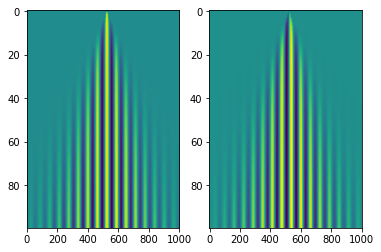

In [5]:
setup = KeysightSingleQubit()
try:
    waveforms_I, waveforms_Q, readout, qubit = generateWaveforms()
    #print (len(waveforms_I))
    setup.loadAndQueueWaveforms(waveforms_I, waveforms_Q, readout, qubit)
    setup.run()
    save_path = r"S:\_Data\180828 - Manipulate cavity and 3D readout - Cooldown 2\Jupyter notebooks\keysight_rabi_test"
    #np.save(os.path.join(save_path, "I"), np.array(setup.data_list_I))
    #np.save(os.path.join(save_path, "Q"), np.array(setup.data_list_Q))
finally:
    setup.AWG_module.stopAll()
    setup.AWG_module.clearAll()
    setup.chassis.close()

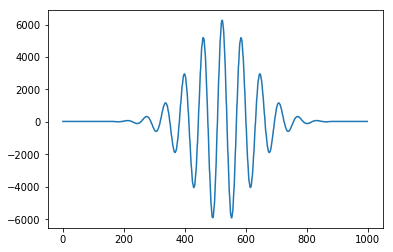

In [4]:
plot(setup.idata[40])

In [ ]:
setup.idata.shape

In [7]:
2*1000*8*100/1e6*100

160.0